#  Spam classification with Naive Bayes


- Libraries
- Exploring the Dataset
- Distribution spam and non-spam plots
- Text Analytics
- Feature Engineering
- Predictive analysis (**Multinomial Naive Bayes and and Gausian Naive Bayes**)
- Conclusion


## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

## Exploring the Dataset

## For this project we are going to use three datasets and combine them together. 

1. Spam email dataset
2. Ham dataset
3. Sms collection dataset.

for the first two datasets, we have to merge the files and manually create the classes and for the third dataset, the Spam-Ham classes are predefined.

In [2]:
# Let's read the email dataset

class FormEmailDataset:
    def __init__(self, path_of_email):
        self.path_of_email = path_of_email
        
    def reading_files(self,path):
        for root, dirnames, filenames in os.walk(path):
            for filename in filenames:
                
                path = os.path.join(root, filename)
                if filename.endswith('.html'):
                    print(path)

                inBody = False
                lines = []
                f = io.open(path, 'r', encoding='latin1')
                for line in f:
                    if inBody:
                        lines.append(line)
                    elif line == '\n':
                        inBody = True
                f.close()
                message = '\n'.join(lines)
                yield path, message
            
    def form_dataframe(self,path, classification): #dataframefromdirectory
        rows = []
        index = []
        for filename, message in self.reading_files(r'{}'.format(path)):
            rows.append({'message': message, 'class': classification})
            index.append(filename)

        return pd.DataFrame(rows, index=index)
    
    def get_data(self):   

        formed_data = pd.DataFrame({'message': [], 'class': []})
        for path_name in os.listdir(self.path_of_email):
            path_of_files = os.path.join(self.path_of_email, path_name)

            formed_data = pd.concat([formed_data, self.form_dataframe(path_of_files, path_name)])
            print(f"{path_name} data we got")
            
        return formed_data
            

In [ ]:

email_dataset = FormEmailDataset(path_of_email='data\emails').get_data()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\emails'

In [8]:
email_dataset

,message,class
data\emails\ham\00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",ham
data\emails\ham\00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",ham
data\emails\ham\00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,ham
data\emails\ham\00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,ham
data\emails\ham\00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",ham
...,...,...
data\emails\spam\00496.1a37de098f6c8847c3c7839d73cc7106,<html>\n\n<head>\n\n<title>Toy</title>\n\n</he...,spam
data\emails\spam\00497.ebf699da617b11135f3aa9173b9781b9,<html>\n\n<head>\n\n<title>Untitled Document</...,spam
data\emails\spam\00498.48c3098854d339353f1a28a13b196017,This is an HTML email message. If you see thi...,spam
data\emails\spam\00499.988506a852cf86b396771a8bdc8cf839,<html>\n\n<head>\n\n</head>\n\n <body backgro...,spam


In [9]:
email_dataset = email_dataset.reset_index(drop=True)
email_dataset.head()

,message,class
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",ham
1,"Martin A posted:\n\nTassos Papadopoulos, the G...",ham
2,Man Threatens Explosion In Moscow \n\n\n\nThur...,ham
3,Klez: The Virus That Won't Die\n\n \n\nAlready...,ham
4,"> in adding cream to spaghetti carbonara, whi...",ham


: 

In [5]:
#let's read the sms data
sms_data = pd.read_csv('https://raw.githubusercontent.com/bigmlcom/python/master/data/spam.csv', sep = '\t')
sms_data.columns = ['class','message']
sms_data = sms_data[['message', 'class']]
sms_data.head()

,message,class
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


## Let's merge them together

In [6]:
data = pd.concat([email_dataset, sms_data])
print("first five data are:\n","=>"*10)
print(data.head(5))

print("last five data are:\n","=>"*10)
print(data.tail(5))

first five data are:
 =>=>=>=>=>=>=>=>=>=>
                                             message class
0      Date:        Wed, 21 Aug 2002 10:54:46 -05...   ham
1  Martin A posted:\n\nTassos Papadopoulos, the G...   ham
2  Man Threatens Explosion In Moscow \n\n\n\nThur...   ham
3  Klez: The Virus That Won't Die\n\n \n\nAlready...   ham
4  >  in adding cream to spaghetti carbonara, whi...   ham
last five data are:
 =>=>=>=>=>=>=>=>=>=>
                                               message class
651                  Anything lor. Juz both of us lor.   ham
652  Get me out of this dump heap. My mom decided t...   ham
653  Ok lor... Sony ericsson salesman... I ask shuh...   ham
654                                Ard 6 like dat lor.   ham
655  Why don't you wait 'til at least wednesday to ...   ham


## Shape of the data

In [7]:
data.shape

(3656, 2)

## Check null values

In [8]:
data.isna().sum()

message    0
class      0
dtype: int64

### We can see that there is no null values in this dataset.



## Let's check for duplicate values

In [10]:
print(f"we have {data.duplicated().sum()} duplicate values found in the dataset. \nBelow are the duplicate data. \n", "=="*20)
data[data.duplicated()]

we have 66 duplicate values found in the dataset. 
Below are the duplicate data. 


,message,class
317,I think that this and other articles confuse S...,ham
318,I think that this and other articles confuse S...,ham
460,i agree with rob. i think if the phones (and m...,ham
787,A friend in Dublin is mailing me the CD which ...,ham
1842,URL: http://scriptingnews.userland.com/backiss...,ham
...,...,...
514,"Sorry, I'll call later",ham
549,"Sorry, I'll call later",ham
560,Ok lor.,ham
581,K. I will sent it again,ham


**As we can see there are some duplicate values. Let's remove keep the first ones.**

In [14]:
data = data.drop_duplicates(keep='first')
data = data.reset_index(drop=True)
data.shape

(3590, 2)

**So we have removed the values which are found duplicated with some other values**

We have now 3590 rows data.

In [15]:
#let's save the dataset
data.to_csv("spamham.csv", index=False)

## Distribution spam/non-spam plots

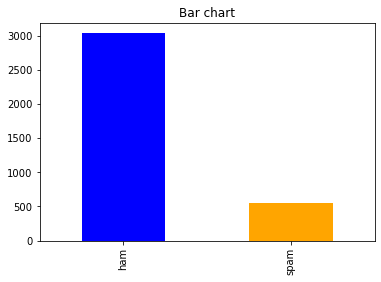

In [14]:
count_Class=pd.value_counts(data["class"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

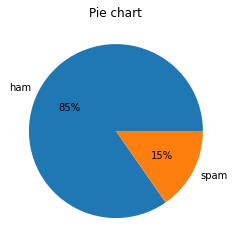

In [15]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Text Analytics

We want to find the frequencies of words in the spam and non-spam messages. The words of the messages will be model features.<p>
We use the function Counter.

In [16]:
count1 = Counter(" ".join(data[data['class']=='ham']["message"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['class']=='spam']["message"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

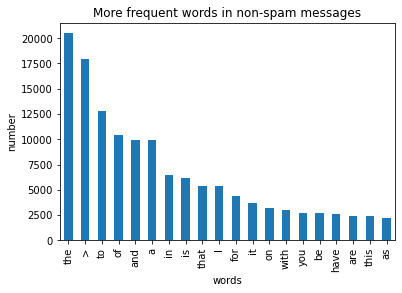

In [17]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

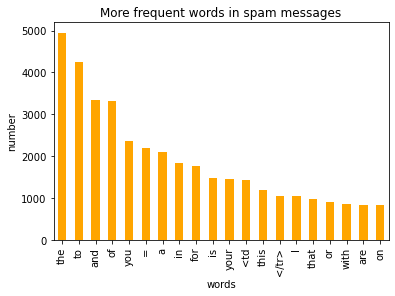

In [18]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on. <p>
With stop words we refer to the most common words in a language, there is no simgle, universal list of stop words. <p>

## Feature engineering

Text preprocessing, tokenizing and filtering of stopwords are included in a high level component that is able to build a dictionary of features and transform documents to feature vectors.<p>
**We remove the stop words in order to improve the analytics**

In [19]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["message"])
np.shape(X)

(3590, 63395)

We have created more than 63395 new features. The new feature $j$ in the row $i$ is equal to 1 if the word $w_{j}$ appears in the text example $i$. It is zero if not.

## Predictive Analysis

**My goal is to predict if a new sms is spam or non-spam. I assume that is much worse misclassify non-spam than misclassify an spam. (I don't want to have false positives)**
<p>
The reason is because I normally don't check the spam messages.<p> The two possible situations are:<p>
1. New spam sms in my inbox. (False negative).<p>
OUTCOME: I delete it.<p>
2. New non-spam sms in my spam folder (False positive).<p>  OUTCOME: I probably don't read it. <p>
I prefer the first option!!!

First we transform the variable spam/non-spam into binary variable, then we split our data set in training set and test set. 

In [20]:
#let's map the values of target column ( class )
data["class"]=data["class"].map({'spam':1,'ham':0})


In [21]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['class'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(2405, 63395), (1185, 63395)]


### Multinomial naive bayes classifier

We train different bayes models changing the regularization parameter $\alpha$. <p>
We evaluate the accuracy, recall and precision of the model with the test set.

In [22]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

Let's see the first 10 learning models and their metrics!

In [23]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998337,0.970464,0.844920,0.963415
1,0.11001,0.990852,0.960338,0.791444,0.948718
2,0.22001,0.990437,0.960338,0.791444,0.948718
3,0.33001,0.988773,0.957806,0.775401,0.947712
4,0.44001,0.987110,0.956962,0.764706,0.953333
5,0.55001,0.985447,0.959494,0.770053,0.966443
6,0.66001,0.983784,0.958650,0.764706,0.966216
7,0.77001,0.982536,0.958650,0.764706,0.966216
8,0.88001,0.980042,0.957806,0.759358,0.965986
9,0.99001,0.977963,0.955274,0.743316,0.965278


let's select the model with the most test precision

In [27]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             1.650010
Train Accuracy    0.972141
Test Accuracy     0.951899
Test Recall       0.716578
Test Precision    0.971014
Name: 15, dtype: float64

**The best model does not produce any false positive, which is our goal.** <p>
Let's see if there is more than one model with 100% precision !

In [31]:
models['Test Precision'].max()

0.9710144927536232

In [32]:
models[models['Test Precision'] == models['Test Precision'].max()].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
15,1.65001,0.972141,0.951899,0.716578,0.971014


Between these models with the highest possible precision, we are going to select which has more test accuracy.

In [33]:
best_index = models[models['Test Precision']==models['Test Precision'].max()]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             1.650010
Train Accuracy    0.972141
Test Accuracy     0.951899
Test Recall       0.716578
Test Precision    0.971014
Name: 15, dtype: float64

#### Confusion matrix with naive bayes classifier

In [34]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,994,4
Actual 1,53,134


* #### We misclassify 56 spam messages as non-spam emails whereas we don't misclassify any non-spam message.